 ## Helsinki City bikes

<b> Dataset description: </b> 

Helsinki City Bikes are shared bicycles available to the public in Helsinki and Espoo metropolitan areas. The main aim of the Helsinki city bike system is to address the so-called last-mile problem present in all distribution networks. The city bikes were introduced in 2016 as a pilot project with only 46 bike stations available in Helsinki. After becoming popular among the citizens, Helsinki city decided to gradually expand the bike network.

<b> Purpose of the research: </b> Based on the dataset make a portrait of the user and see what patterns can be traced.

<b>Objective:</b>
- Figure out does weekends affect number of rides
- Determine if temperature affects users behavior
- Find out what hours are the most popular
- Compare radial and station to stations rides
- Display on a map the most popular stations 

<b> The research consists of the following steps:</b>
   1. [Prepare data types](#Preparing)
   2. Work with outliers
   3. Analyse data 
  
 * How does an average ride looks like?
 * How does an average ride distance looks like?
 * How many rides each year?
 * Number of rides on weekends/weekdays
 * Difference in ride duration between weekends and weekdays
 * Dependence of rides number on temperature
 * Dependence of speed on temperature
 * Heatmap of depatrure hours
 * Comparison between radial and no radial rides duration
 * Stations map
 * Popular stations map.

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 

import plotly.express as px
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster
import folium
from folium import plugins

## General information about dataset

In [2]:
cycle = pd.read_csv('database.csv')

In [4]:
cycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12157458 entries, 0 to 12157457
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   departure               object 
 1   return                  object 
 2   departure_id            object 
 3   departure_name          object 
 4   return_id               object 
 5   return_name             object 
 6   distance (m)            float64
 7   duration (sec.)         float64
 8   avg_speed (km/h)        float64
 9   departure_latitude      float64
 10  departure_longitude     float64
 11  return_latitude         float64
 12  return_longitude        float64
 13  Air temperature (degC)  float64
dtypes: float64(8), object(6)
memory usage: 1.3+ GB


In [5]:
cycle.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9


"##Preparing\n"

<a name="Preparing"></a>

First let's rename some columns and change "spaces" with "_" as it more convenient to work with 

In [3]:
cycle.columns = [x.replace(' ', '_')\
                  .replace('(', '')\
                  .replace(')', '')\
                  .replace('.', '') for x in cycle.columns.values]

Now let's change the data colums to data format.

In [4]:
cycle['departure'] = pd.to_datetime(cycle['departure'], format='%Y.%m.%d %H:%M:%S')
cycle['return'] = pd.to_datetime(cycle['return'], format='%Y.%m.%d %H:%M:%S')

cycle['distance_m'] = cycle['distance_m'].astype('int')
cycle['duration_sec'] = cycle['duration_sec'].astype('int')

Then add columns with year and distance in km for working with charts

In [5]:
cycle['year_departure'] = cycle['departure'].dt.year
cycle['departure_date'] = cycle['departure'].dt.date.astype('datetime64[ns]')
cycle['distance_km'] = cycle['distance_m']/1000

Let's see how much data we have for each year

In [9]:
cycle.groupby('year_departure')['return'].count()

year_departure
2016     408100
2017    1606808
2018    3225904
2019    3787557
2020    3129089
Name: return, dtype: int64

 Helsinki City bikes were founded in 2016 and quickly developed with more bike stations in 2017 and 2018, we see that in numbers of rides  

## Outlier Detection

### outlier - distance


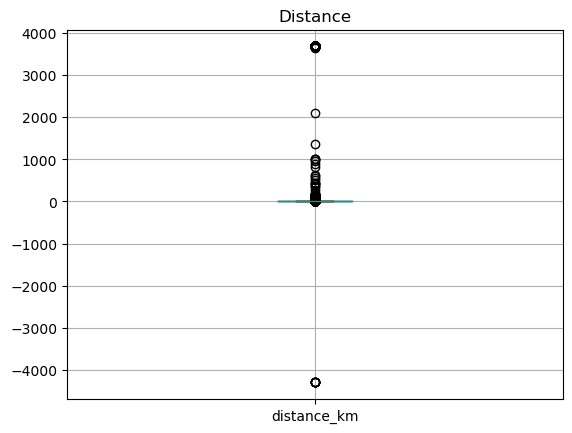

In [10]:
cycle.boxplot('distance_km')
plt.title('Distance')
plt.show()

Whoa, more than 3000 km... There are some tough people in Finland. Let's take a close look to average trips

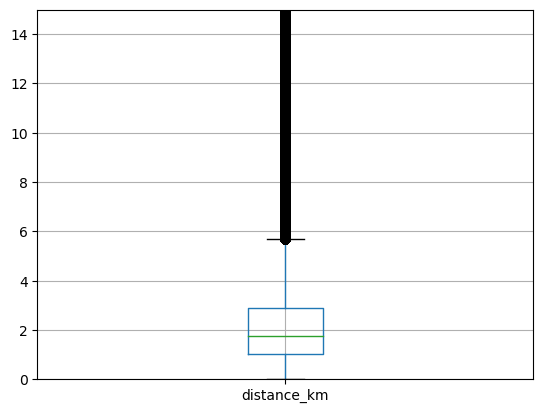

In [11]:
plt.ylim(0, 15)
cycle.boxplot('distance_km')
plt.show()

However in average people ride from 1 to 3 km. How many negative values do we have?

In [12]:
cycle[cycle['distance_km'] < 0]['departure'].count()

7

as it's only 7 lines with negative numbers - remove them and let's see what other short distance is better to be removed


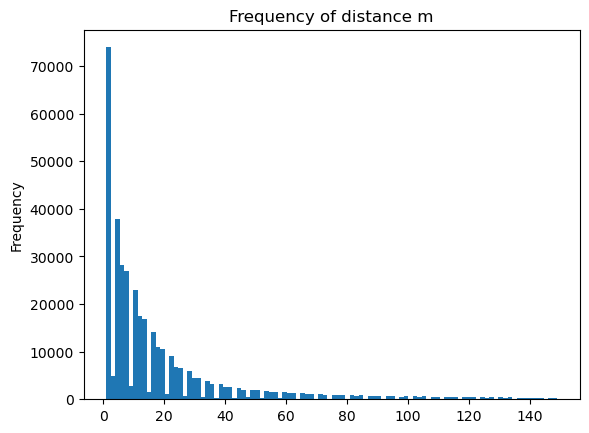

In [13]:
cycle.query('0 < distance_m < 150')['distance_m'].plot(kind='hist',bins=100)
plt.title('Frequency of distance m')
plt.show()

See lot's of 0, probably couldn't start the ride, so I remove all that is less then 100 meters as it also looks like some troubles with bikes or an app

In [6]:
cycle_cleaned = cycle[cycle['distance_m'] > 100].copy()

Now, we need to see the tail of distance, and remove some 'marathon' riders. First let's see how many ultra marathon riders, who rode more than 1000

In [15]:
cycle_cleaned[cycle_cleaned['distance_km'] > 1000]['departure'].count()\
            /cycle_cleaned['distance_km'].count()*100

0.00464480029067686

The others I've divided into 100 groups, 1 group 1-10 km, 2nd 11-20 etc

In [16]:
# set intervals
bins = list(range(0, 1000, 10))

#assign each ride an interval
cycle_cleaned['groups_distance'] = pd.cut(cycle_cleaned['distance_km'], bins=bins, right=False)

In [17]:

groups = cycle_cleaned.groupby('groups_distance')['distance_km'].count()
groups.head(7)

groups_distance
[0, 10)     11370482
[10, 20)       35920
[20, 30)        2981
[30, 40)         455
[40, 50)         118
[50, 60)          42
[60, 70)          25
Name: distance_km, dtype: int64

Since the first three groups are the vast majority - omit them on our plot

In [18]:
groups = groups[3:51]


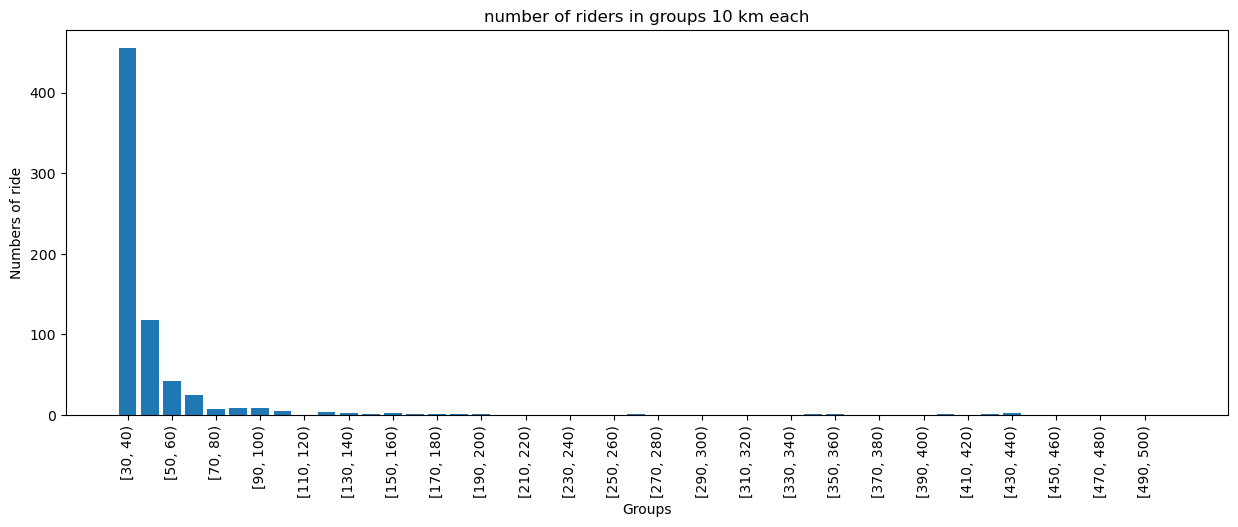

In [19]:
#barplot to see which rides we can remove from out dataset
plt.figure(figsize = (15,5))
plt.bar(groups.index.astype(str), groups.values)
plt.title('number of riders in groups 10 km each')
plt.xlabel('Groups')
plt.ylabel('Numbers of ride')
plt.xticks(groups.index[::2].astype(str))
plt.xticks(rotation=90)
plt.show()

In [20]:
cycle_cleaned[cycle_cleaned['distance_km'] > 100]['departure'].count()/cycle_cleaned['distance_km'].count()*100

0.0049340048370774955

0.005 % rode more that 100km Let's remove them

In [7]:
cycle_cleaned = cycle_cleaned[cycle_cleaned['distance_km'] < 100]

### outlier - velocity

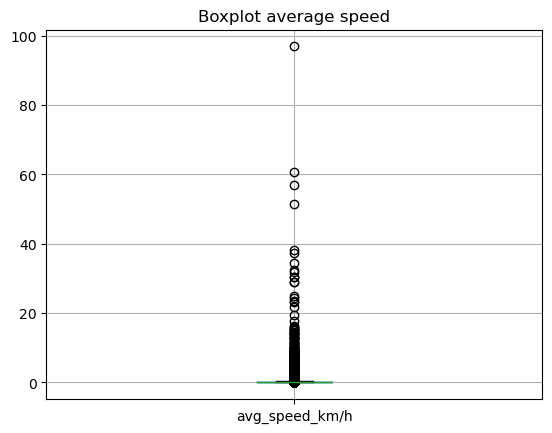

In [22]:
cycle_cleaned.boxplot("avg_speed_km/h")
plt.title('Boxplot average speed')
plt.show()

Pretty slow riders, could they be in a traffic jam? I'll make a column where I calculate speed - V = S / T.
It seems that the numbers we see in avg_speed_km/h	- are in reality km/min

In [9]:
cycle_cleaned['calc_speed'] = cycle_cleaned['distance_km']/(cycle_cleaned['duration_sec']/60/60)

New box plot with km/h

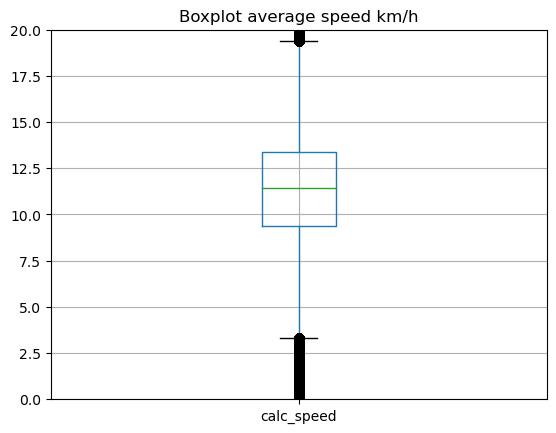

In [24]:
plt.ylim(0, 20)
cycle_cleaned.boxplot('calc_speed')
plt.title('Boxplot average speed km/h')
plt.show()

Looks much more close to life. The website says that the speed on bikes limited to 25 km/h, so everything that is more - errors

In [10]:
cycle_cleaned = cycle_cleaned[cycle_cleaned['calc_speed'] <= 25]

### outlier - duration

I made one more colum with duration in hours - as it more convinient than seconds

In [11]:
cycle_cleaned['duration_hours'] = cycle_cleaned['duration_sec']/60/60

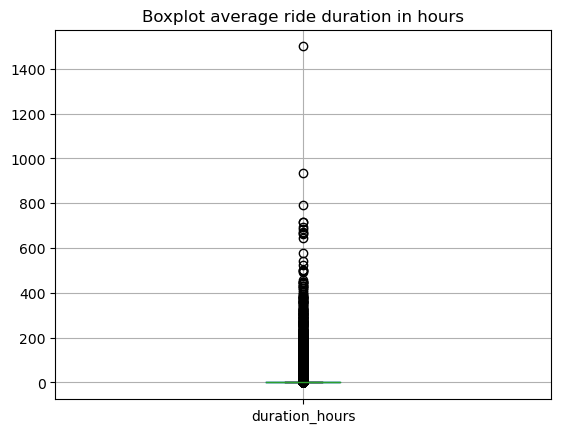

In [27]:

cycle_cleaned.boxplot('duration_hours')
plt.title('Boxplot average ride duration in hours')
plt.show()

In [12]:
#I calculated some reasonable rent period - 1 day looks like it
cycle_cleaned[cycle_cleaned['duration_hours'] > 24]['departure'].count()

6203

As people who rented bikes for more than 24 hours 4387, that is less than 1 % so I removed them

In [13]:
cycle_cleaned = cycle_cleaned[cycle_cleaned['duration_hours'] <= 24]

In [14]:
cycle_cleaned.to_csv('Cycle_cleaned.csv', index=False) 

In [15]:
cycle_cleaned.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance_m,duration_sec,avg_speed_km/h,departure_latitude,departure_longitude,return_latitude,return_longitude,Air_temperature_degC,year_departure,departure_date,distance_km,calc_speed,duration_hours
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747,401,0.261397,60.195245,24.901900,60.197572,24.926781,0.9,2020,2020-03-23,1.747,15.683791,0.111389
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447,869,0.099908,60.168610,24.930537,60.165017,24.949473,0.9,2020,2020-03-23,1.447,5.994476,0.241389
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772,469,0.226695,60.195540,25.053581,60.187234,25.036412,0.9,2020,2020-03-23,1.772,13.601706,0.130278
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456,2406,0.185935,60.227827,24.819614,60.203474,24.898930,0.9,2020,2020-03-23,7.456,11.156110,0.668333
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120,1679,0.254437,60.158928,24.909692,60.186463,24.967872,0.9,2020,2020-03-23,7.120,15.266230,0.466389


## Analysis

### How does an average ride looks like?

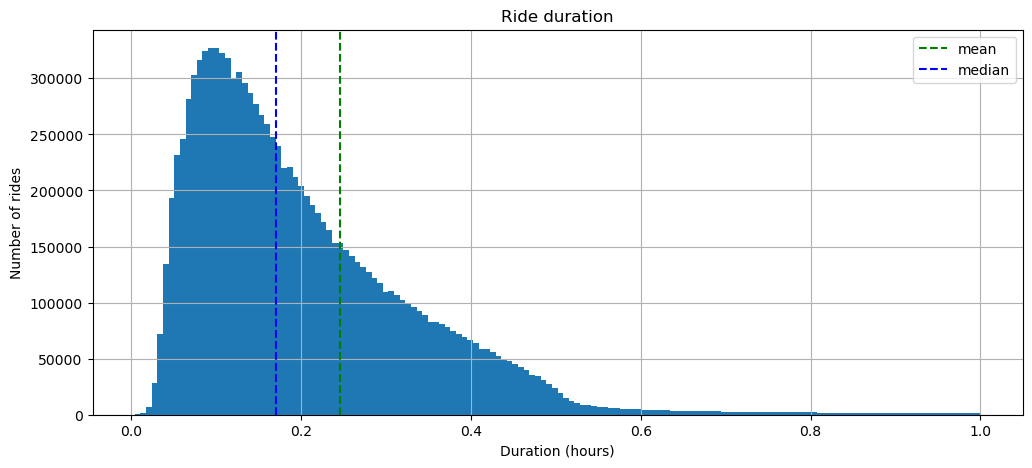

In [30]:
plt.figure(figsize = (12,5))

ax = cycle_cleaned.query('duration_hours < 1')['duration_hours'].hist(bins = 150)
ax.axvline(x = cycle_cleaned['duration_hours'].mean(), color = 'g', linestyle = 'dashed', label = 'mean')
ax.axvline(x = cycle_cleaned['duration_hours'].median(), color = 'b', linestyle = 'dashed', label = 'median')


plt.legend()
plt.ylabel('Number of rides')
plt.xlabel('Duration (hours)')
plt.title('Ride duration')
plt.show()

In [31]:
print('Average ride duration:',round(cycle_cleaned['duration_hours'].mean()*60, 2))
print('Median ride duration:',round(cycle_cleaned['duration_hours'].median()*60, 2))

Average ride duration: 14.76
Median ride duration: 10.27


### How does an average ride distance looks like?

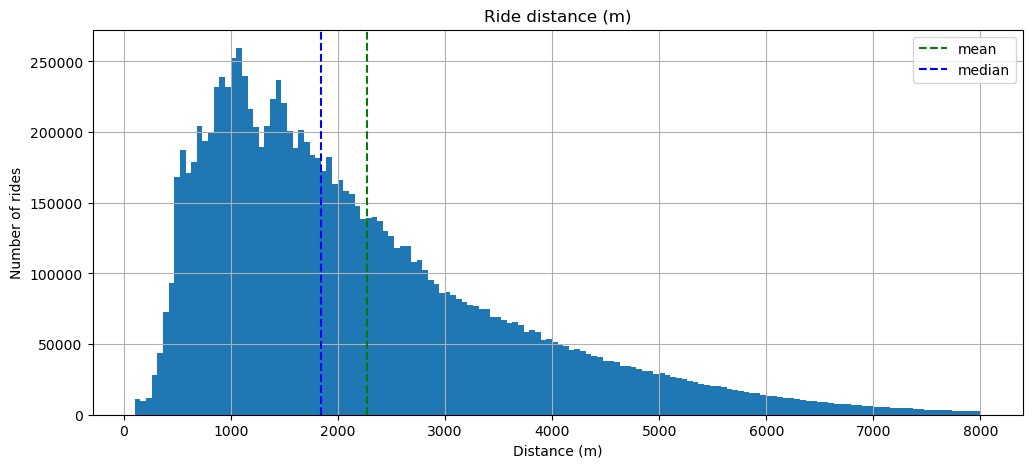

In [32]:
plt.figure(figsize = (12,5))

ax = cycle_cleaned.query('distance_m < 8000')['distance_m'].hist(bins = 150)
ax.axvline(x = cycle_cleaned['distance_m'].mean(), color = 'g', linestyle = 'dashed', label = 'mean')
ax.axvline(x = cycle_cleaned['distance_m'].median(), color = 'b', linestyle = 'dashed', label = 'median')


plt.legend()
plt.ylabel('Number of rides')
plt.xlabel('Distance (m)')
plt.title('Ride distance (m)')
plt.show()

In [33]:
print('Average ride distance:', round(cycle_cleaned['distance_m'].mean(), 2))
print('Median ride distance:', round(cycle_cleaned['distance_m'].median(), 2))

Average ride distance: 2270.69
Median ride distance: 1845.0


What's a usual bike ride like? 
Here is a right-skewed distribution If we check out the rides over the past 5 years, we find that most rides take about 15 minutes, covering around 2270 meters. As more rides are on the shorter side, from 4 to 10 minutes, and go about 1800 meters. The city bicycle system was designed to solve last mile problem and based on these graphs looks like they succeeded in it. 

### How many rides each year?

Let's see how many rides we have durig the whole period

In [34]:
cycle_cleaned['departure_date'] = pd.to_datetime(cycle_cleaned['departure_date'], format='%Y.%m.%d')

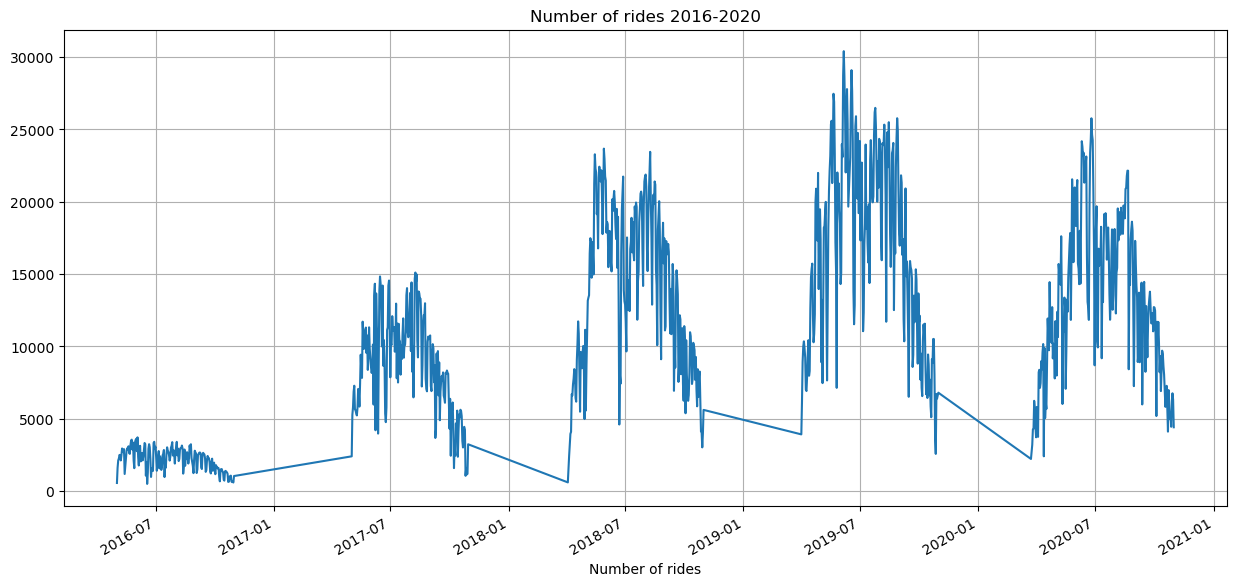

In [35]:
plt.figure(figsize = (15,7))
cycle_cleaned.groupby('departure_date')['departure'].count().plot(grid=True)
plt.title('Number of rides 2016-2020')
plt.xlabel('Number of rides')
plt.show()

The graph above shows the number of daily bike rides since the launch of the City bike service. Making the network bigger really boosts the number of trips. However in 2020, the bike usage went down, which might be because of COVID-19 or because the bike network stopped growing. Now, let's check if more people use it on weekends.

### Number of rides on weekends/weekdays

In [61]:
#create extra columns to determine weekends
cycle_cleaned['is_weekend'] = cycle_cleaned['departure_date'].dt.dayofweek.isin([5, 6])
cycle_cleaned['count'] = 1
#date to obj
cycle_cleaned['departure_date'] = cycle_cleaned['departure_date'].dt.strftime('%Y-%m-%d')

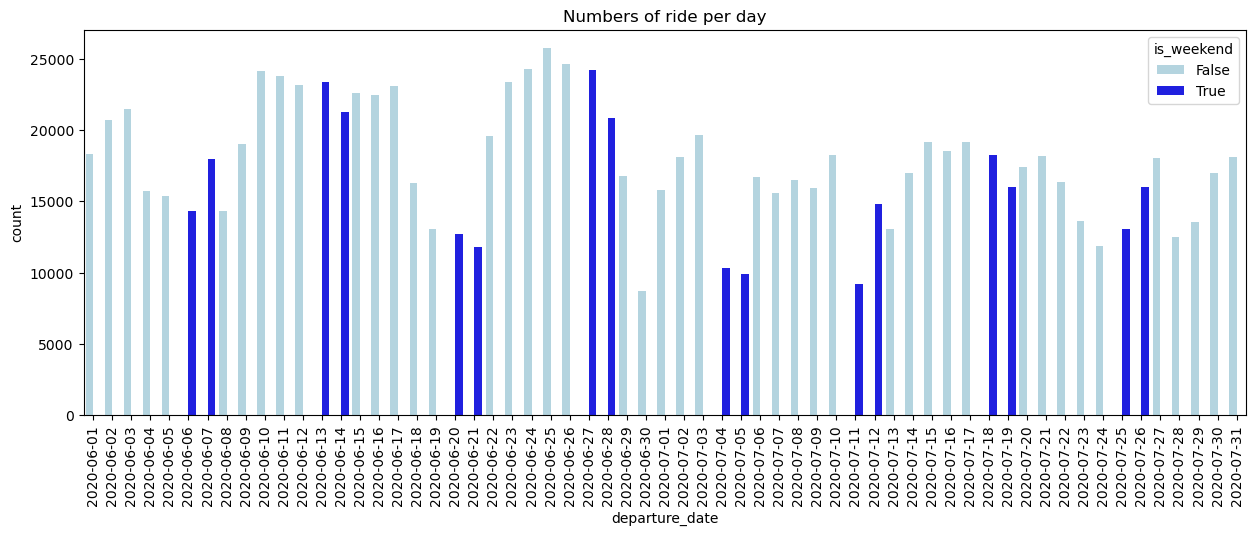

In [68]:
#make a barplot
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='departure_date',
            y='count',
            hue="is_weekend",
            data=cycle_cleaned.query("'2020-06-01' <= departure_date < '2020-08-01'"),
          
            estimator=sum,
            palette=['lightblue', 'blue'])


plt.title('Numbers of ride per day')
plt.xticks(rotation=90)
plt.show()

Surprisingly weekends are no more popular than weekdays. Usually there are less rides during weekends, sometimes significantly

### Difference in ride duration between weekends and weekdays

Let's see if there is a difference between ride duration in weekends and weekdays

In [23]:
duration_work_weekend = cycle_cleaned.groupby(['year_departure', 'is_weekend'])['duration_hours'].mean()

In [94]:
duration_work_weekend = duration_work_weekend.reset_index()

year_departure  is_weekend
2016            False         0.270985
                True          0.397805
2017            False         0.263779
                True          0.340131
2018            False         0.238296
                True          0.282828
2019            False         0.235839
                True          0.280774
2020            False         0.255056
                True          0.294805
Name: duration_hours, dtype: float64

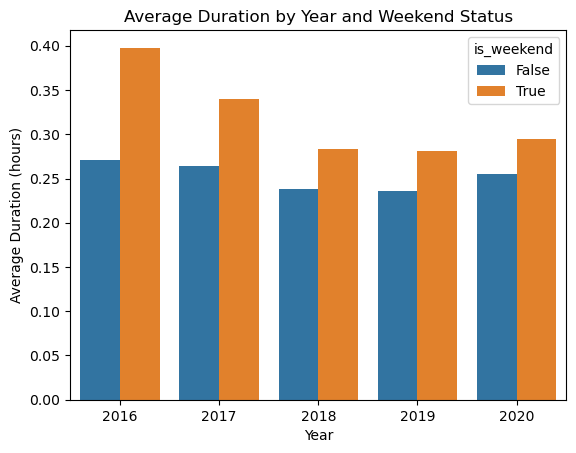

In [33]:
# make a barplot
sns.barplot(x='year_departure', y='duration_hours', hue='is_weekend', data=duration_work_weekend)

plt.title('Average Duration by Year and Weekend Status')
plt.xlabel('Year')
plt.ylabel('Average Duration (hours)')

plt.show()


As we can see the average duration during weekday is a little sorter than in weekends. In average it's about 10 minutes longer in weekends 

### Dependence of rides number on temperature

Let's make a pivot table and see if number of rides correlate with temperature. I used rolling to make the figures more readable 

In [112]:
cycle_cleaned['departure_date'] = pd.to_datetime(cycle_cleaned['departure_date'], format='%Y.%m.%d')

df = pd.pivot_table(cycle_cleaned.query('year_departure != [2016, 2017]'), 
               index='departure_date', 
               values=['departure', 'Air_temperature_degC', 'calc_speed'],
                aggfunc={'departure': 'count', 'Air_temperature_degC': 'mean', 'calc_speed': 'mean'}
               )

df.reset_index(inplace= True )

#seperate variables for x y axes
x = df['departure_date']
y1 = df['departure'].rolling(15).mean()
y2 = df['Air_temperature_degC'].rolling(15).mean()
y3 = df['calc_speed'].rolling(15).mean()


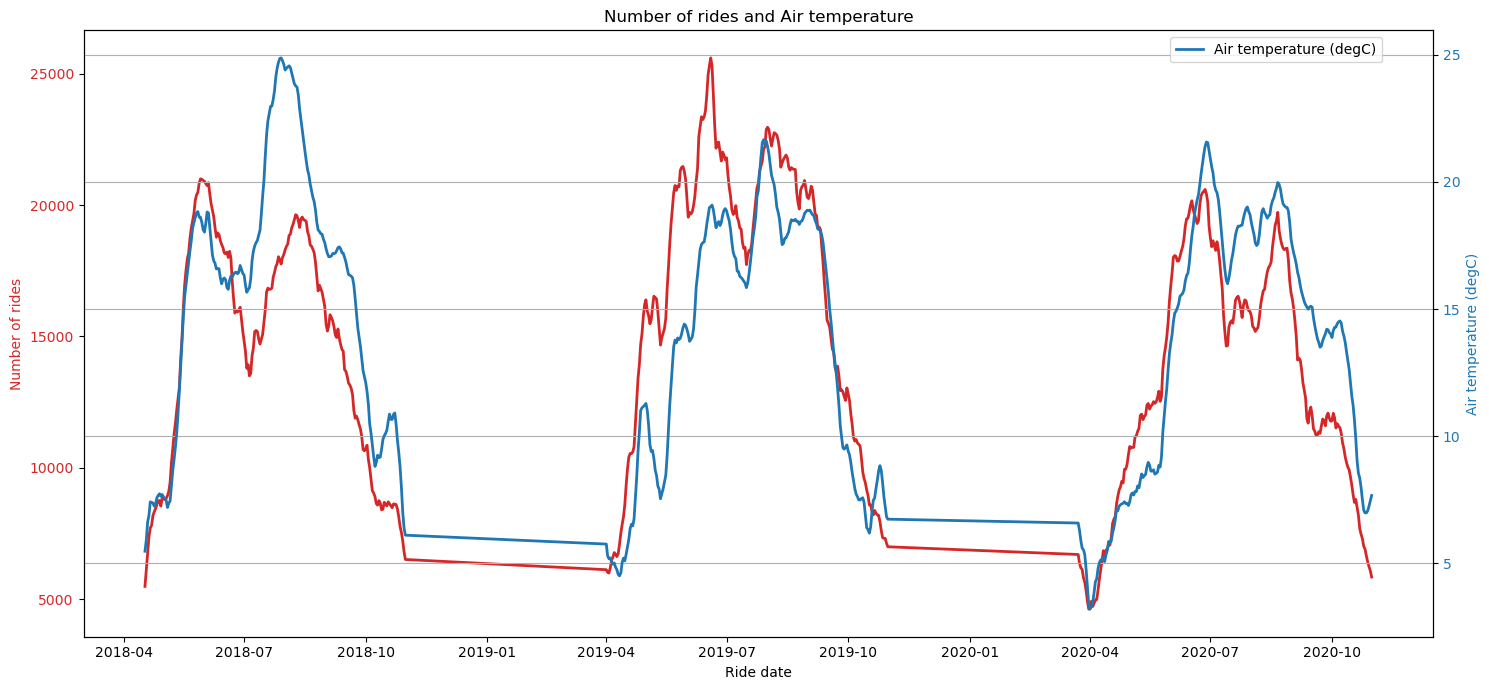

In [116]:
plt.figure(figsize=(15, 7))

# Create first subplot
plt.plot(x, y1, color='tab:red', label='Number of rides',  linewidth=2)
plt.xlabel('Ride date')
plt.ylabel('Number of rides', color='tab:red')
plt.tick_params(axis='y', labelcolor='tab:red')

# Create second y-axis
plt.twinx()
plt.plot(x, y2, color='tab:blue', label='Air temperature (degC)', linewidth=2)
plt.ylabel('Air temperature (degC)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')


# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))

# Title and layout
plt.title('Number of rides and Air temperature')
plt.tight_layout()
plt.grid(True)

# Show the plot
plt.show()

Let's see correlation

In [127]:
print(df['departure'].corr(df['Air_temperature_degC']))

0.7544418811364155


We can see pretty strong dependance in raise of temperature and numbers of rides. Bike rent drops to minimum before winter season. 

### Dependence of speed on temperature

We can see that service doesn't work during winter time. What can we say about speed? Does it correlare with the temperature?

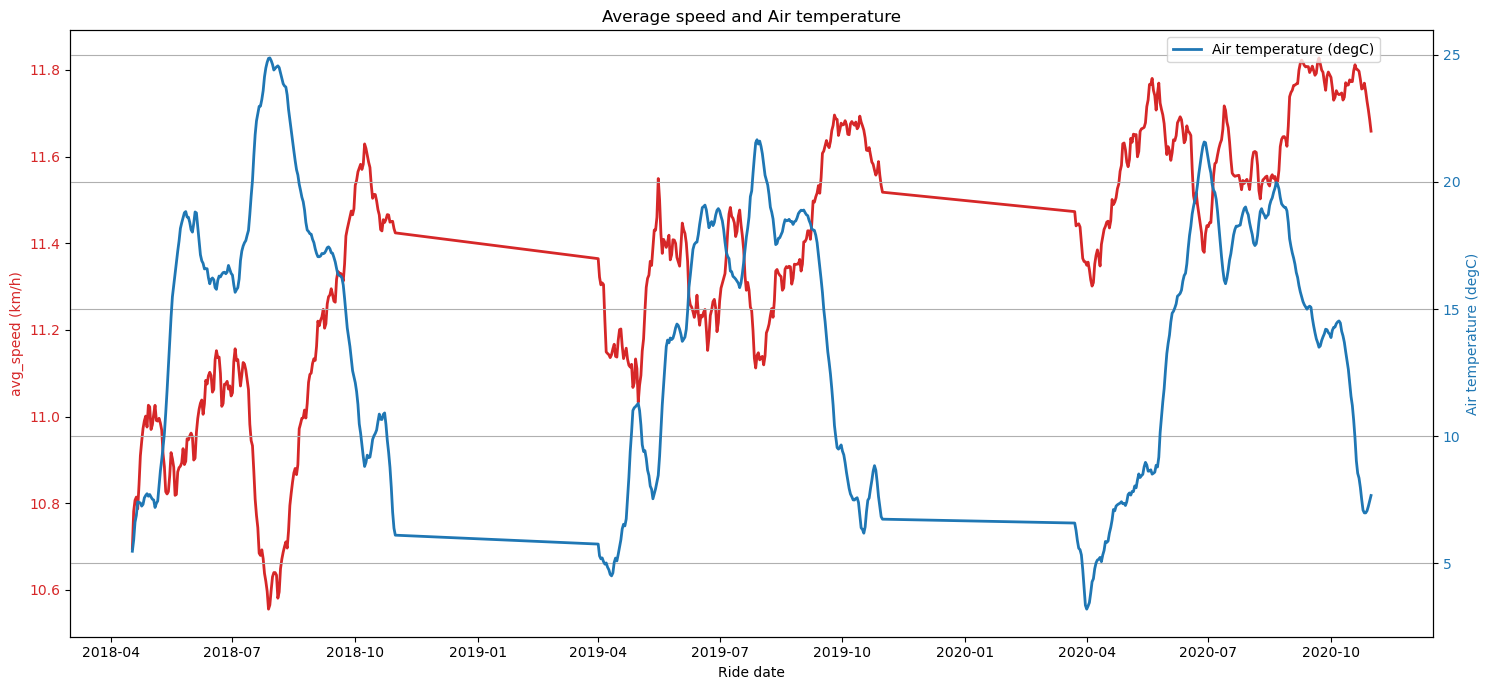

In [119]:
plt.figure(figsize=(15, 7))

# Use a single subplot
plt.plot(x, y3, color='tab:red', label='avg_speed (km/h)', linewidth=2)
plt.xlabel('Ride date')
plt.ylabel('avg_speed (km/h)', color='tab:red')
plt.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis
plt.twinx()
plt.plot(x, y2, color='tab:blue', label='Air temperature (degC)', linewidth=2)
plt.ylabel('Air temperature (degC)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))

# Title and layout
plt.title('Average speed and Air temperature')
plt.tight_layout()
plt.grid(True)

# Show the plot
plt.show()

In [129]:
print(df['calc_speed'].corr(df['Air_temperature_degC']))

-0.26722014327103355


The theory was not confirmed and cyclists do not speed up when it's warmer.

### Heatmap of depatrure hours 

Let's see how activity differs depends on hours

In [69]:

weekdays = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]

# Data
data = cycle_cleaned.copy()
data["hour"] = pd.DatetimeIndex(data['departure']).hour
data["weekday"] = pd.DatetimeIndex(data['departure']).weekday
daily_activity = data.groupby(by=['weekday','hour']).count()['departure'].unstack()


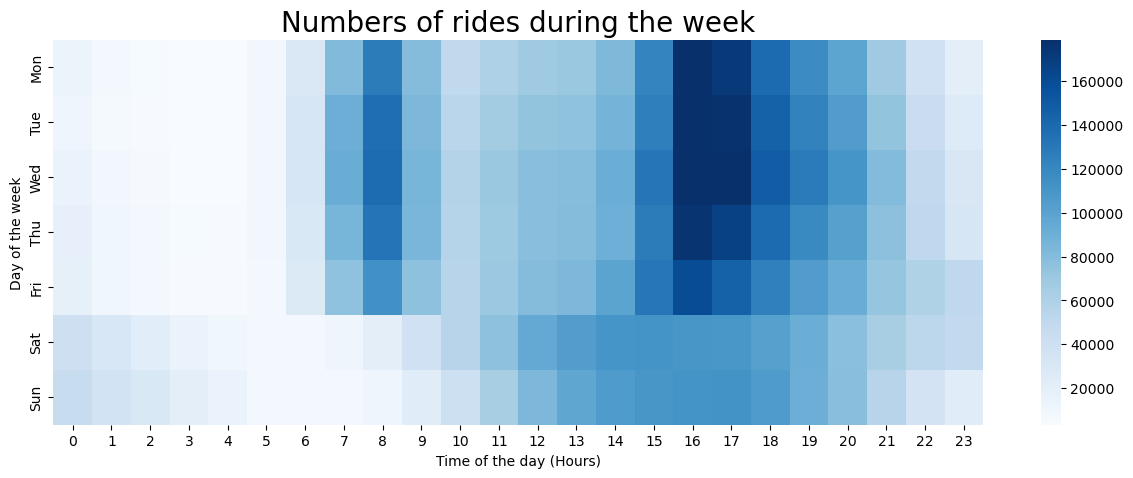

In [74]:

# heatmap
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(daily_activity, robust=True, cmap="Blues", yticklabels=weekdays) 

# Labeling Axes
plt.xlabel("Time of the day (Hours)")
plt.ylabel("Day of the week")
plt.title('Numbers of rides during the week', fontsize= 20)

plt.show()



Looking at the picture above, we can see when people use bikes the most. Weekdays show busy times from 7:00 to 9:00, evening rush hours are more extended from 15:00 to 18:00, suggesting people use bikes a lot for work travel. It also looks like City Travel users prefer to get back from work by bike than riding to work.

On weekends, it's a bit different. People in Helsinki seem to start their weekend activities a bit later, with the peak hours between 14:00 and 19:00. 



### Comparison between radial and no radial rides duration

In [81]:
radial_rides = cycle_cleaned[cycle_cleaned['departure_name'] == cycle_cleaned['return_name']]\
                                        .groupby(['year_departure'])['duration_hours']\
                                        .agg(['mean', 'count']).reset_index()
radial_rides['count'].sum()

266864

In [85]:
no_radial_rides = cycle_cleaned[cycle_cleaned['departure_name'] != cycle_cleaned['return_name']]\
                                        .groupby(['year_departure'])['duration_hours']\
                                        .agg(['mean', 'count']).reset_index()
no_radial_rides['count'].sum()

11119406

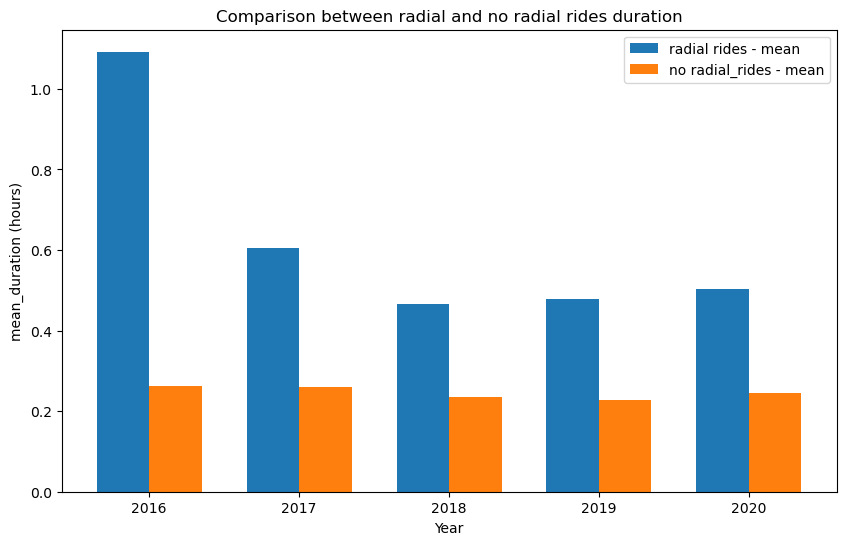

In [86]:
# Creating a plot
fig, ax = plt.subplots(figsize=(10, 6))

# column width
bar_width = 0.35

# column positions
bar_positions1 = np.arange(len(no_radial_rides))
bar_positions2 = bar_positions1 + bar_width

# Creation columns
ax.bar(bar_positions1, radial_rides['mean'], bar_width, label='radial rides - mean')
ax.bar(bar_positions2, no_radial_rides['mean'], bar_width, label='no radial_rides - mean')

# plot setting
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels(radial_rides['year_departure'])
ax.set_xlabel('Year')
ax.set_ylabel('mean_duration (hours)')
ax.legend()

plt.title('Comparison between radial and no radial rides duration')
plt.show()

When people have radial rides (the start and the end points are the same)it's usualy twice longer. However this type of rides are not popular and number of radial rides is 40 times less than from one point to another  

### Stations map

In [37]:
where_the_stations = cycle_cleaned.loc[:,['departure_name', 'departure_latitude', 'departure_longitude']]

In [38]:
where_the_stations = where_the_stations.drop_duplicates()


In [39]:
    
# latitude and longitude
hels_lat, hels_lng = 60.20063355838791, 24.90789626240413

# Helsenki map
m_1 = Map(location=[hels_lat, hels_lng], zoom_start=11)


# create an empty claster
marker_cluster = MarkerCluster().add_to(m_1)

def create_clusters(row):
    Marker(
        [row['departure_latitude'], row['departure_longitude']],
        popup=f"{row['departure_name']}",
          ).add_to(marker_cluster)
    
where_the_stations.apply(create_clusters, axis=1)

m_1

### Popular stations map

In [40]:
count = cycle_cleaned.query('year_departure == 2019').groupby('departure_name')['return_id'].count().reset_index()


In [41]:

where_the_stations = pd.merge(where_the_stations, count, on=['departure_name'])

In [42]:
where_the_stations['frequency_adj'] = where_the_stations['return_id']/(where_the_stations['return_id'].median()/3)

In [43]:
hel_map = Map([60.1975594, 24.9320720], zoom_start=12)
#folium.TileLayer('cartodbdark_matter').add_to(hel_map)

for index, row in where_the_stations.iterrows():
    folium.CircleMarker([row['departure_latitude'],row['departure_longitude']],
                    radius=row["frequency_adj"],
                    popup=row['departure_name'],
                    color="blue",
                    fill_color="#ADD866",
                ).add_to(hel_map)

hel_map

The map above shows how bikes were used in different parts of Helsinki in 2019. Expectedly, the central area, where a lot of the economic and cultural evens happen, is the busiest in terms of people moving around. 

<b>Conclusion:</b>


A typical user of city bicycles usually rides for approximately 15 minutes to cover a distance of 2 kilometers  from one station to another. This is more common on weekdays, especially during the morning rush hours from 7 to 9 am,  and more likely in the evening until 6 pm. On weekends, people in Helsinki tend to rent bikes a bit later, starting from 11 am. The weekend rides are a little longer, 10 minutes longer in average. Radial rides are not veery popular - around 2.5%, engage in twice longer rides.

In Finland, cycling is embraced even when the temperature is as low as 5 degrees Celsius. Interestingly, he higher the temperature is the more readily people use bikes, although riders don't necessarily pedal faster as the weather gets warmer.

The most favored bike stations are concentrated in the city center, with additional clusters in Leppavaara and Aalto-yliopisto.